# Tutorial 1: GRB Population Inference with MCMC (Structured Jet)

> **Origin**: cleaned tutorial version of `MAGGPY_fj.ipynb`  
> **Full production version**: see `MAGGPY_fj.ipynb` in this folder (includes extra Fermi catalogue, GRINTA, and unified plotter cells).

This tutorial walks through the complete workflow of:
1. Setting up the simulation environment
2. Defining the GRB model parameters
3. Running an MCMC to infer population properties
4. Analyzing and visualizing the results

## Import Libraries

We start by importing all necessary libraries and configuring matplotlib for better visualization.

In [7]:
# Auto-reload modules for interactive development
%load_ext autoreload
%autoreload 2
import notebook_setup # needed for Jupyter notebooks

# Import core modules
from    src import init, posteriors, plots_oop 
import  emcee
import  numpy                   as np 
import  matplotlib.pyplot       as plt
from    math                    import inf
from    pathlib                 import Path
from    src.montecarlo          import log_likelihood, DEFAULT_LIMITS
from    src.prior_factory       import create_log_prior, log_prior, initialize_walkers
from    src.multiprocessing_MC  import run_mcmc_parallel 

# Apply custom plotting style
plt.style.use('../configurations/style.mplstyle')

# Configure matplotlib color cycle for better visualization
import matplotlib as mpl 
import matplotlib.colors as mcolors
colors_for_cycle = [
    mcolors.to_hex(c) for c in plt.cm.plasma(np.linspace(0, 1, 3))
]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors_for_cycle)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


After importing all the libraries necessary to run this code, proceed by creating your directory.

In [8]:
# Where to find the datafiles and save the outputs
datafiles   = Path("../datafiles")
output_dir  = init.create_run_dir("tutorial1") # Create a new output directory for this tutorial

Loading existing directory  : Output_files/tutorial1


The `create_run_dir` is a helper to automatically create your run directory.

# Define the Model Constants

To understand the model parameters the Monte Carlo (MC) simulation makes the following assumptions:

 ➡ The single GRB photon Spectrum is given by a Broken power law (Eq. (1) [here](https://arxiv.org/abs/1711.03106)):

$$
N_E^{\text{SBPL}} = A E_j^\alpha \left[ \left( \frac{E}{E_j} \right)^{- \alpha n} + \left( \frac{E}{E_j} \right)^{- \beta n} \right]^{-\frac{1}{n}} \tag{A.1}
$$

The peak energy ($E_\text{peak}$) of $E^2N_E$ and the energy scale / energy break $E_j$ are related by:

$$
E_j = E_\text{peak} \epsilon
$$

Where $\epsilon = \left( -\frac{\alpha+2}{\beta+2} \right)^{\frac{1}{(\beta - \alpha)n}}$. $n$ is a smoothing parameter. Changing $\alpha$ and $\beta$ will change the slope of the rise/fall of the $E^2N_E$. As can be see in 

<div align="center"> <img src="../images/BPL.jpg" alt="Spectral Slopes" width="30%"> </div>

 ➡ The structure of the jet is fixed with $\theta_c$, and the maximum viewing angle is $\theta_v^{max}$. By default they are $3.4^\circ$ and $10^\circ$ respectively. The jet is assumed to be a cone with a half-opening angle $\theta_c$.

In [9]:
# GRB Jet structure assumptions
params = {
    "alpha"         : -0.67,    # 2/3 from synchrotron
    "beta_s"        : -2.59,    # Average value from GRBs
    "n"             : 2,        # Smoothly broken power law curvature
    "theta_c"       : 3.4,      # Ghirlanda half-angle of jet core (from GW170817)
    "theta_v_max"   : 10,       # Maximum viewing angle of the jet (in degrees)
    "z_model"      : 'fiducial_Hrad_A1.0'    #? Optional, model to use for redshift distribution
}

## Photon Spectrum and Temporal Evolution

The photon spectrum can be written as
$$
N(E, \theta_v, t) = N_0(\theta_v, t) f\left( \frac{E}{E_0(\theta_v, t)} \right). \tag{A.2}
$$

Where $f(x)$ is the Broken power law from **Eq. (A.1)**. With the peak energy:

$$
E_0(\theta_v, t) = E_0(\theta_v, t=t_p) P_E\left( \frac{t}{t_p}, \theta_v \right), \tag{A.3}
$$

where $ t_p $ denotes the peak time of the pulse and $ P_E $ represents the temporal profile, which depends on the viewing angle $ \theta_v $. Similarly, the normalization of the photon spectrum is written as

$$
N_0(\theta_v, t) = N_{0}(\theta_v, t=t_p) P_N\left( \frac{t}{t_p}, \theta_v \right). \tag{A.4}
$$

## Temporal and Angular Profiles

Both the the peak energy and photon spectrum have the following temporal profiles:

$$
P_N(t, tp, \theta_v) =
\begin{cases}
\dfrac{t}{tp} & \text{if } t < tp \\
\left( \dfrac{t}{tp} \right)^{-\alpha_n(\theta_v)} & \text{otherwise}
\end{cases}, \quad \quad
P_E(t, tp, \theta_v) =
\begin{cases}
1 & \text{if } t < tp \\
\left( \dfrac{t}{tp} \right)^{-\alpha_e(\theta_v)} & \text{otherwise}
\end{cases}
$$

And the following angular profiles (evaluated at $t=t_p$):

$$

R_{E}(\theta_v) = \frac{E_0(\theta_v)}{E_0(\theta_v=0)} = \frac{E_0(\theta_v)}{\hat{E}_0},

\quad \quad 
R_F(\theta_v) = \frac{N_0(\theta_v)|_{E=E_0(\theta_v)}}{\hat{N_0}|_{E=\hat{E}_0}}
$$

As such 8 functions are **precomputed**:
- $\alpha_E(\theta_v)$ and $\alpha_N(\theta_v)$
- $R_{E}(\theta_v)$ and $R_F(\theta_v)$
- $I_0 = \int_{E_1}^{E_2} xf(x)dx$, $I_1 = \int_{E_1'}^{E_2'} xf(x)dx$, $I_2 = \int_{E_1'}^{E_2'}f(x)dx$ and $I_3 = \int_{E_1''}^{E_2''} xf(x)dx$

Found in the `default_interpolator` dictionaries. Specifically the integrals $I_i$ are precomputed to simplify/speed-up a few calculations from the [original paper](https://www.aanda.org/articles/aa/pdf/2022/09/aa43705-22.pdf). 

<div style="padding: 15px; border: 1px solid #d6e9c6; border-radius: 4px; color: #1f421fff; background-color: #6fa05aff;"> <strong>Notice:</strong> All these functions are defined within <code>src.montecarlo</code> and the original paper if you need a deeper explanation.</div>

In [10]:
default_params, default_interpolator, data_dict = init.initialize_simulation(datafiles, params) #? Catalogue data from fermi GBM

Using redshift model: samples_fiducial_Hrad_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year


## Likelihood

The `emcee` package is used to sample a 7 dimensional parameter space. To be as agnostic as possible flat priors are used. 

#### GRB Prior Parameters

---

<div align="center">

| Parameter | Description | Range | Units |
|-----------|-------------|--------|--------|
| $k$ | Power-law index of spectral function | $[1.5, 12]$ | - |
| $L_{L0}$ | $Log_{10}$ Isotropic energy scale | $[-3, 2]$ | - |
| $L_{\mu E}$ | $Log_{10}$ of mean peak energy | $[2.5, 4]$ | keV |
| $\sigma_E$ | Width of peak energy distribution | $[0, 1]$ | - |
| $L_{\mu \tau}$ | $Log_{10}$ of mean peak time | $[-2, 0.301]$ | s |
| $\sigma_\tau$ | Width of peak time distribution | $[0, 1.8]$ | - |
| $f_j$ | Jet beaming fraction | $[0, 10]$ | - |

</div>

---

**Physical Interpretations:**

➡ To calculate the "scale" of the photon spectrum for $\theta_v = 0$ and $t = t_p$ we need the rest frame on-axis isotropic energy $\hat{E}_{iso}$. The original paper goes into detail on how to calculate it, for simplicity know that the "scale" of $\hat{E}_{iso}$ is controlled by $L_{L0}$ with a distribution that is a cut-off power law of slope $k$. Note that it is adimensional because in the code $L0$ is normalized to $10^{49}$ erg.

➡ $L_{\mu \tau}$: Peak times from 10 ms to 2s, the 2s is the maximum cut-off from catalogue given that the peak time is always smaller than $t_{90}$.

➡ $f_j$: Fraction of BNS producing jets (linear scale).

#### `emcee` Likelihood

Given how the `emcee` package works the "likelihood" also contains the steps for generating the GRBs from a set of parameters. In other words the way the likelihood is defined is as follows:

1. Extract parameters and check them against the priors.
2. Generate a GRB from the parameters. (the function `log_likelihood` from `montecarlo.py` follows the same structure as the original paper)
3. From the sample of GRBs two sub-samples are created : 
    - **$(t_{90} < 2\text{s}$, $F_p > 4 \text{ph/cm}^2/\text{s})$**, this is compared to the $\approx 18$ GRBs/yr detected by Fermi. Giving a Poissonian likelihood term: 
    $$p_0 = \text{Poiss}(N_{\text{GRBs}} | \lambda)$$
    - **$(t_{90} < 2\text{s}$, $F_p > 4 \text{ph/cm}^2/\text{s})$ and $E_p \in (50\,\text{keV}, 10\,\text{MeV})$**, used to compare the observables from our generated GRBs to those from the catalogue with the Cramér-von Mises test:  
    $$p_i = \text{CvM}(D_{\text{obs}}^i, D_{\text{gen}}^i)$$
4. Overall the final likelihood is: 
$$
\mathcal{L}(N_{\text{GRBs}}, \vec{D_{\text{obs}}}|\lambda, \vec{D_{\text{gen}}}) = p_0 \prod_i p_i
$$

As the MCMC is running the progress is saved in the `.h5` file. The `.h5` file contains the samples of the MCMC, and can be used to restart the MCMC.

### Creating the prior function

The prior in most cases is defined by flat priors. To quickly generate a function we have a helper function that takes your desired ranges and creates the prior function. For more complicated priors you can define your own prior function.

In [11]:
custom_bounds = {
             'k'        : (1.5, 12),
             'L_L0'     : (-3, 2),
             'L_mu_E'   : (2.5, 4),
             'sigma_E'  : (0, 1),
             'L_mu_tau' : (-2, np.log10(2)), # put a maximum at 2 seconds as the real distribution is with a 2 second mean, this is shifted, so we really don't expect high values
             'sigma_tau': (0, 1.8),
             'f_j'      : (0, 10)
}
my_prior = create_log_prior(custom_bounds)

In [12]:
def log_probability(thetas, default_params=default_params, default_interpolator=default_interpolator):
    # add a bit of noise to the parameters
    lp = my_prior(thetas)	
    
    if not np.isfinite(lp):
        return -inf, 0, 0, 0, 0, 0

    l_out = log_likelihood(thetas, params=default_params, interps=default_interpolator)
    
    if not np.isfinite(l_out[0]):
        return -inf, 0, 0, 0, 0, 0

    return lp + l_out[0], l_out[1], l_out[2], l_out[3], l_out[4], l_out[5]

initial             = np.array([2, -0.51, 3.19, 0.35, -0.1, 0.54, 0.5])
ex_log_likelihood   = log_probability(initial)[0]
print(f"Example log likelihood: {ex_log_likelihood:.2f}")

Example log likelihood: -98.20


## Setting Up an MCMC Sampling with emcee

Running `emcee` is thoroughly explained in the [documentation](https://emcee.readthedocs.io/en/stable/tutorials/line/) for the package. As a quick refresher there are a few parameters that need to be set:

➡ `NWALKERS` : The number of walkers in the MCMC. More walkers can explore the parameter space more thoroughly. As a rule of thumb, should be at least twice the number of parameters.

➡ `TOTAL_STEPS` : Total number of steps for each walker. More steps allow the walkers to explore the parameter space more thoroughly.

➡ `DISCARD` : Number of initial samples to discard as burn-in. These samples are removed before analysis since the chain needs time to converge.

In [21]:
# MCMC configuration parameters
NWALKERS    	= 20        # Number of walkers (should be >= 2 * number of parameters)
TOTAL_STEPS 	= 1_000     # Total MCMC steps per walker
DISCARD         = 300     # Number of samples to discard for burn-in

# Initialize walker positions randomly within the prior bounds
pos = initialize_walkers(NWALKERS) 
print(f"Example walker position: {pos[0]}")

Example walker position: [ 2.81537406 -1.23869599  3.01832743  0.22646903 -0.86627783  0.85538438
  0.62914719]


### Create Backend for Saving MCMC Progress

The backend saves the MCMC chain to an HDF5 file, allowing you to:
- Resume interrupted runs
- Access results without re-running the MCMC
- Analyze convergence and diagnostics

In [14]:
# Create the backend to save MCMC progress to an HDF5 file
filename    = output_dir / "emcee.h5"
backend     = emcee.backends.HDFBackend(filename)

## Running the MCMC

The `run_mcmc_parallel` function uses multiprocessing to speed up convergence by running likelihood evaluations in parallel. The sampler will:
1. Start from the initial walker positions
2. Explore the parameter space for `TOTAL_STEPS`
3. Save progress to the backend file automatically

**Note:** By default, `workers=None` uses all available CPU cores. You can manually set this to a specific number if needed.

In [15]:
# Run the MCMC with parallel processing
sampler = run_mcmc_parallel(
    max_n           =   TOTAL_STEPS,
    backend         =   backend,
    initial_pos     =   pos,      
    log_probability =   log_probability,  
    workers         =   None,  # Use all available CPUs (change to a number to limit cores)
)

100%|██████████| 1000/1000 [01:20<00:00, 12.36it/s]

Mean acceptance fraction: 0.045
MCMC sampling finished successfully.


## Plotting the Results / Convergence

### Initialize the Plotting Object

We begin by defining the `MCMCPlotter` object which provides convenient methods for analyzing and visualizing MCMC results. 

The plotter needs:
- `samplers`: List of backend objects containing MCMC chains
- `names`: Labels for each chain (useful when comparing multiple runs)
- `output_dir`: Where to save plots
- `burn_in`: Number of initial samples to discard
- `thin`: Thinning factor to reduce autocorrelation
- `ranges`: Prior ranges for each parameter (for plotting bounds)

In [22]:
# Define plotting ranges for each parameter (must match the prior bounds)
plotting_ranges = np.array([
    [1.5, 12],              # k: Power-law index
    [-3, 2],                # L_L0: Log10 isotropic energy scale
    [2, 4],                 # L_mu_E: Log10 mean peak energy
    [0.05, 1],              # sigma_E: Width of peak energy distribution
    [-2, np.log10(2)],      # L_mu_tau: Log10 mean peak time
    [0.05, 1.8],            # sigma_tau: Width of peak time distribution
    [0, 5]                  # f_j: Jet beaming fraction
])

# Create the plotter object
plotter = plots_oop.MCMCPlotter(
        samplers    =   [backend],
        names       =   ['Fiducial Model'],
        output_dir  =   output_dir,
        burn_in     =   DISCARD, 
        thin        =   15,         # Thin by factor of 15 to reduce autocorrelation
        ranges      =   plotting_ranges,
)

### Loading Pre-existing Results (Optional)

To avoid re-running the MCMC, you can load a previously saved backend. If you've just run the MCMC above, you can skip this step and continue using the current `backend` object.

In [23]:
# Example: Load a different backend file
# backend = emcee.backends.HDFBackend("path/to/your/saved_chain.h5")

### Convergence Diagnostics

The convergence plot shows how the detected GRB rate evolves as the MCMC progresses. If the chain has converged, you should see the rate stabilize around the observed value (shown as a horizontal line).

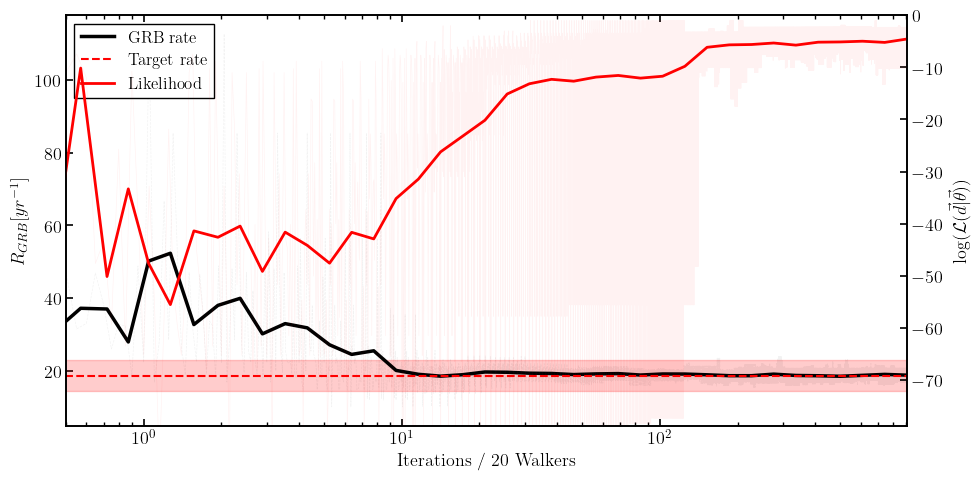

In [24]:
# Plot the evolution of the GRB detection rate over MCMC steps
plotter.plot_convergence(n_counts=default_params.yearly_rate)

### Autocorrelation Time Analysis

The autocorrelation time ($\tau$) measures how many steps it takes for the chain to "forget" its initial conditions. 

**Rule of thumb:** The chain has converged if $\tau < N/50$, where $N$ is the total number of steps. If $\tau$ is too large, you may need to run more steps.

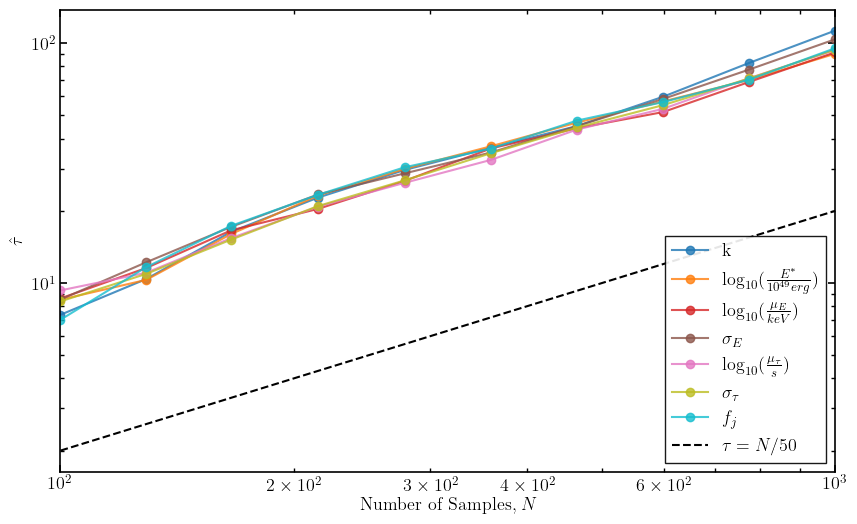

In [25]:
# Calculate and plot autocorrelation times for each parameter
plotter.plot_autocorrelation_times()

### Corner Plot

Corner plots display:
- **Diagonal:** 1D marginalized posterior distributions for each parameter
- **Off-diagonal:** 2D joint distributions showing parameter correlations

This visualization helps identify degeneracies and understand the posterior structure.

<div class="alert alert-info" role="alert">
  <strong>Tip:</strong> Multiple chains can be compared by passing arrays of backends and names to the plotter.
</div>

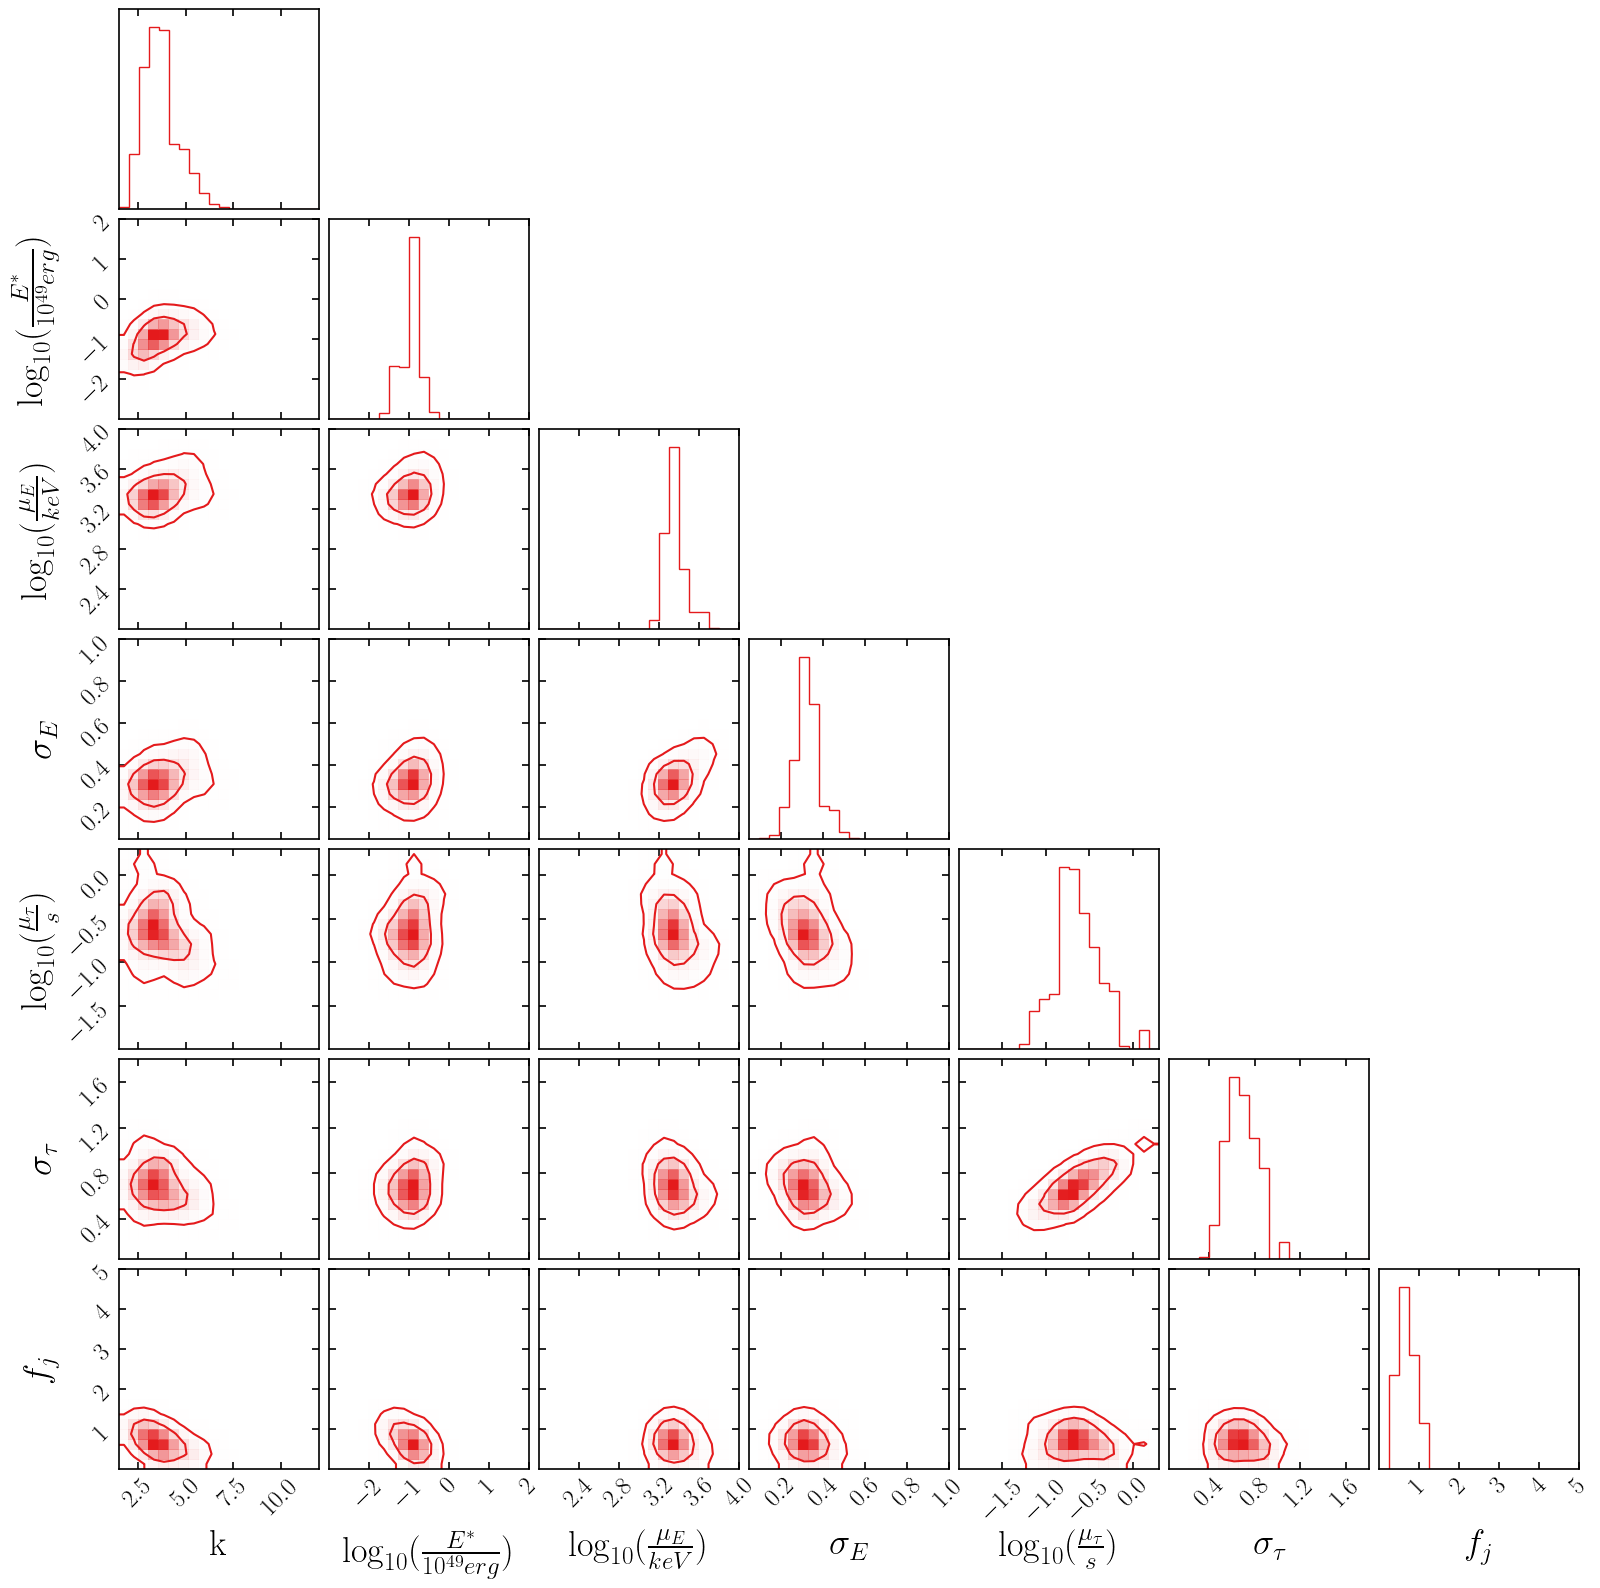

In [26]:
# Create a corner plot showing all parameter distributions and correlations
fig = plotter.create_corner_plot()

### Parameter Summary Table

This function displays the median and 90% confidence intervals for all parameters. The table is also formatted for LaTeX, making it easy to include in publications.

In [27]:
# Display parameter summary with median and 90% credible intervals
table = plotter.show_parameter_table()

<IPython.core.display.Math object>

## Additional Convergence Diagnostics

These plots provide deeper insights into the MCMC behavior and help ensure the chain has properly converged.

### Autocorrelation and Parameter Exploration

The diagnostic plots show two key aspects:

**Left panels - Parameter Exploration:** Shows how each walker explores the parameter space over time. 
- ✓ **Good:** "Fuzzy caterpillar" - walkers mixing well across the parameter space
- ✗ **Bad:** "Worm-like" - walkers stuck or not exploring efficiently

**Right panels - Autocorrelation Function:** Measures how quickly the chain becomes independent.
- ✓ **Good:** Drops to zero quickly
- ✗ **Bad:** Stays high - indicates strong correlation between successive samples

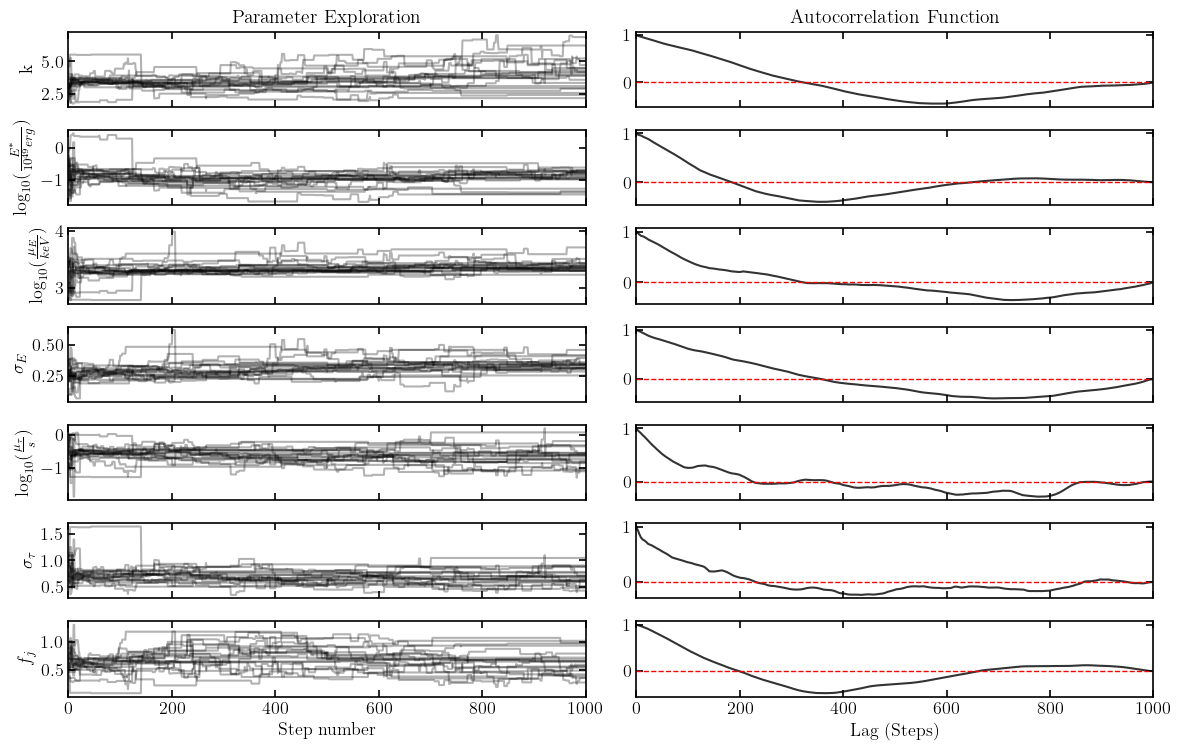

In [28]:
# Create diagnostic plots showing autocorrelation and walker exploration
plotter.plot_diagnostics()

### Likelihood Evolution

Track how individual likelihood components evolve over the MCMC run. This helps diagnose if certain data constraints are being satisfied and how the chain converges to the optimal region.

### Posterior Predictive Checks

These checks are more rigorous as they directly compare the data / model you are using to generated samples. The `extract_samples_and_calculate_cdfs` generates observables that you can study, and `plot_cdf_comparison` compares the empirical and simulated Cumulative Distributions.

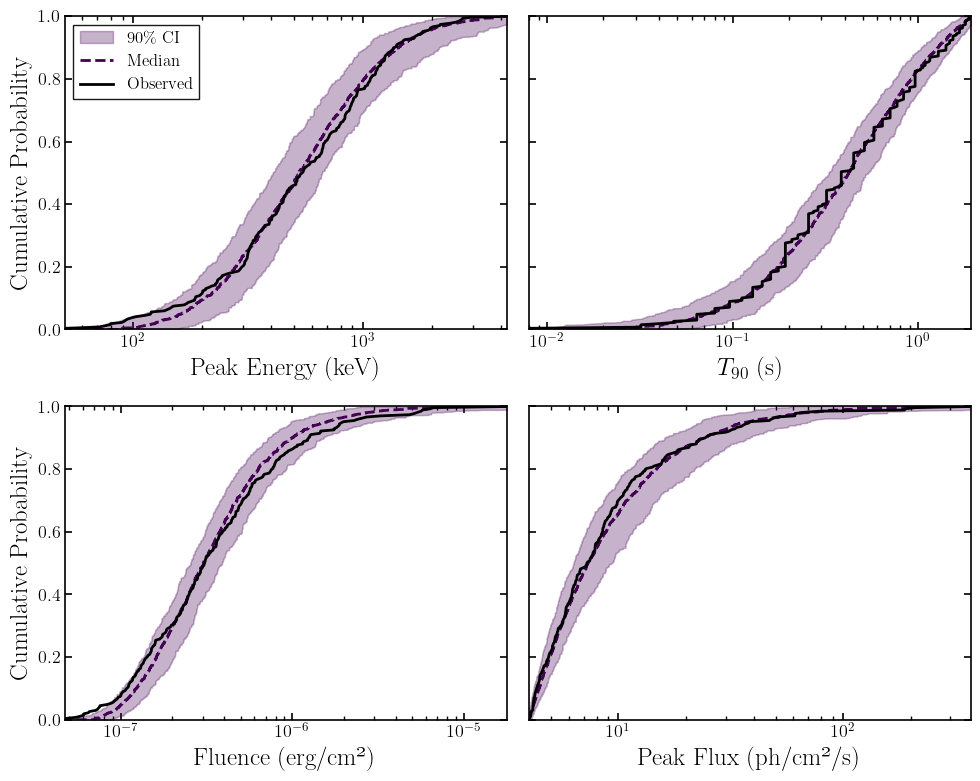

(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: xlabel='Peak Energy (keV)', ylabel='Cumulative Probability'>,
         <Axes: xlabel='$T_{90}$ (s)'>],
        [<Axes: xlabel='Fluence (erg/cm²)', ylabel='Cumulative Probability'>,
         <Axes: xlabel='Peak Flux (ph/cm²/s)'>]], dtype=object))

In [29]:
# Extract samples from the posterior and generate the corresponding observables (flux, T90, Hardness)
dict_data = posteriors.extract_samples_and_calculate_cdfs(
    backend, 
    default_params, 
    default_interpolator, 
    discard = DISCARD,  # Ignore the initial burn-in samples
    flatten = False,    # Keep the walker structure
    choices = 150       # Number of random samples to draw from the posterior
)

# Plot the comparison between the observed data (data_dict) and the simulated data (dict_data)
# The output will be saved in the output_dir
plots_oop.plot_cdf_comparison(data_dict, [dict_data], output_dir=output_dir)

The resulting plot will show the Cumulative Distribution Functions (CDFs) of the observables from the catalogue (black) compared to the distribution of CDFs generated from the posterior samples (colored bands). This allows us to visually verify if our model can reproduce the observed data.